## Анализ A/B тестирования двух вариантов дизайна веб-страницы (старый дизайн vs новый дизайн) 


Текущий коэффициент конверсии составляет около 12%. 
UX-дизайнер разработал новый вариант страницы товара, надеясь повысить коэффициент конверсии.
Заказчики хотят увеличить конверсию на 2%.
=> если новая версия страницы увеличит конверсию до 14%, ее можно будет считать успешной.

Сформулируем две гипотезы (Н0 и Н1):
    
H₀ (нулевая гипотеза): конверсия нового и старого дизайна не различается \
H₁ (альтернативная гипотеза): конверсия различается

Зададим уровень значимости α = 0.05 (5%)


Нам нужны две группы пользователей: 

**Контрольная** группа – видит старый дизайн \
**Экспериментальная** группа – видит новый дизайн 

Это будет независимая переменная, так как мы меняем только один фактор – дизайн страницы. Это позволяет контролировать другие переменные (например, сезонность) и точно определить влияние нового дизайна.

Зависимая переменная – коэффициент конверсии. Для кодирования используем бинарную переменную:

**0** – пользователь не совершил покупку \
**1** – пользователь совершил покупку

Таким образом, среднее значение в каждой группе будет равно коэффициенту конверсии.    
    


In [16]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

Подсчитаем необходимый размер выборки для A/B - теста с помощью Power Analysis (анализ мощности).

In [98]:
# sms.proportion_effectsize() вычисляет размер эффекта (effect size) 
# по двум пропорциям (текущая конверсия 0.13 и ожидаемая 0.15).
# Размер эффекта показывает, насколько сильно отличается новое значение от старого.
effect_size = sms.proportion_effectsize(0.12, 0.14)

# solve_power() решает уравнение мощности теста и возвращает количество наблюдений, 
# необходимых в каждой группе.
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, # вероятность найти реальную разницу, если она есть (обычно 80%).
    alpha=0.05, 
    ratio=1 # равное количество наблюдений в контрольной и тестовой группах.
    )                                                 

required_n = math.ceil(required_n)
print(f'Количество пользователей, необходимое в каждой группе: {required_n}')

Количество пользователей, необходимое в каждой группе: 4433


In [99]:
effect_size

-0.05951079608252363

In [100]:
df = pd.read_csv('/Users/Dobrosha/Downloads/ab_data.csv')

In [101]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [103]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [104]:
df.shape

(294478, 5)

In [105]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [106]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [107]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [108]:
df.columns.tolist()

['user_id', 'timestamp', 'group', 'landing_page', 'converted']

Проверим корректность данных. В идеале контрольная группа (control) должна видеть только old_page, а экспериментальная (treatment) — new_page.

**pd.crosstab(df['group'], df['landing_page'])** — это быстрый способ убедиться, что каждая группа в A/B-тесте видит правильную версию страницы

Что делать? Попробуем посмотреть дубли пользователей.


In [109]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


Столбцы: \
    **user_id** – ID пользователя \
    **timestamp** – Дата и время сеанса \
    **group** – Группа эксперимента (control или treatment) \
    **landing_page** – Какую страницу видел пользователь (old_page или new_page) \
    **converted** – Была ли конверсия (0 – нет, 1 – да) 

В нашем анализе мы будем использовать только столбцы **group** и **converted**.

In [110]:
user_duplicates = df.groupby('user_id', as_index=False).agg({'group':'count'}) \
.rename({'group':'users_cnt'}, axis=1).query("users_cnt > 1").count().user_id

print(f'В датасете {user_duplicates} пользователей, которые появляются несколько раз')

В датасете 3894 пользователей, которые появляются несколько раз


Удалим из датасета этих пользователей.

In [111]:
session_counts = df['user_id'].value_counts(ascending=False)
users_to_drop = session_counts[session_counts > 1].index

In [112]:
df.shape

(294478, 5)

In [113]:
df = df[~df['user_id'].isin(users_to_drop)]

In [114]:
df.shape

(286690, 5)

Теперь после удаления дубликатов пользователей каждая группа в A/B-тесте видит правильную версию страницы

In [115]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


Теперь случайно выберем 4720 записей для каждой группы (control и treatment).

In [116]:
# Метод .sample сделает рандомную выборку:
control_sample = df[df['group'] == 'control'].sample(n=required_n)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n)

Проверка данных

In [117]:
control_sample.head()

,user_id,timestamp,group,landing_page,converted
219941,910189,2017-01-10 18:28:15.862757,control,old_page,0
215477,752513,2017-01-12 20:42:52.559193,control,old_page,0
214012,757545,2017-01-10 02:32:39.790753,control,old_page,0
276684,740593,2017-01-24 05:18:44.209816,control,old_page,0
278776,825423,2017-01-06 17:44:40.014434,control,old_page,0


In [118]:
control_sample.group.unique()

array(['control'], dtype=object)

In [119]:
treatment_sample.head()

,user_id,timestamp,group,landing_page,converted
277498,666793,2017-01-05 10:54:05.504705,treatment,new_page,0
155319,654927,2017-01-08 12:52:34.474131,treatment,new_page,0
16048,756465,2017-01-17 01:10:12.472546,treatment,new_page,0
26617,856784,2017-01-17 03:37:31.587726,treatment,new_page,1
181520,902838,2017-01-15 13:42:20.155972,treatment,new_page,0


In [120]:
treatment_sample.group.unique()

array(['treatment'], dtype=object)

In [121]:
ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [122]:
ab_test.head()

,user_id,timestamp,group,landing_page,converted
0,910189,2017-01-10 18:28:15.862757,control,old_page,0
1,752513,2017-01-12 20:42:52.559193,control,old_page,0
2,757545,2017-01-10 02:32:39.790753,control,old_page,0
3,740593,2017-01-24 05:18:44.209816,control,old_page,0
4,825423,2017-01-06 17:44:40.014434,control,old_page,0


In [123]:
ab_test.group.unique()

array(['control', 'treatment'], dtype=object)

In [124]:
ab_test.shape
# 4433 + 4433

(8866, 5)

In [125]:
ab_test.head()

,user_id,timestamp,group,landing_page,converted
0,910189,2017-01-10 18:28:15.862757,control,old_page,0
1,752513,2017-01-12 20:42:52.559193,control,old_page,0
2,757545,2017-01-10 02:32:39.790753,control,old_page,0
3,740593,2017-01-24 05:18:44.209816,control,old_page,0
4,825423,2017-01-06 17:44:40.014434,control,old_page,0


In [126]:
ab_test['group'].value_counts()

control      4433
treatment    4433
Name: group, dtype: int64

Сначала посчитаем основные **статистические показатели**:

1. Средняя конверсия
2. Стандартное отклонение конверсии
3. Стандартная ошибка конверсии

In [127]:
conversion_rates = ab_test.groupby('group')['converted']

# функция для вычисления стандартного отклонения пропорции
# ddof=0 указывает, что используется нормализация на количество значений (для выборки)
std_value = lambda x: np.std(x, ddof=0)

# функция для вычисления стандартной ошибки пропорции
se_value = lambda x: stats.sem(x, ddof=0)  

conversion_rates = conversion_rates.agg([np.mean, std_value, se_value])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.005
treatment,0.123,0.328,0.005


На первый взгляд, новый дизайн немного лучше (12.0% против 12.3%).

/var/folders/4r/l6jgz7s11rs2s5hc02k5l7z00000gn/T/ipykernel_1820/2159428254.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False, palette="pastel")  # Можно использовать палитры, такие как "muted", "deep", "dark", "pastel"


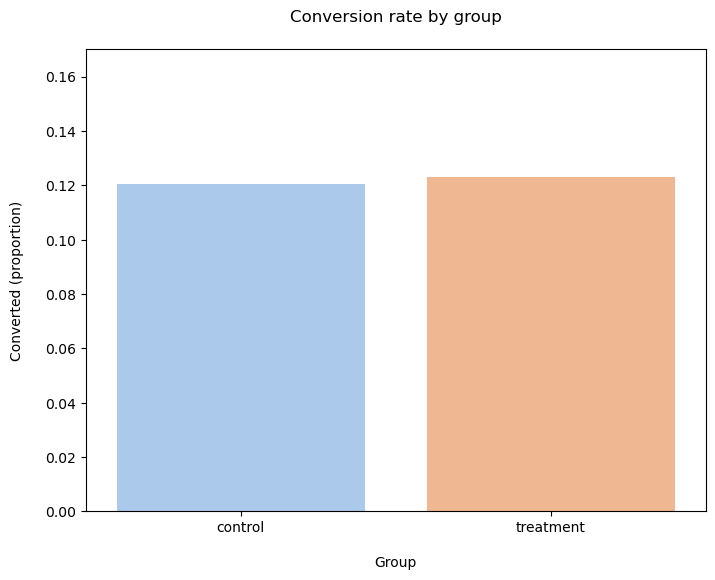

In [134]:
# Построим бар плот:
import seaborn as sns
import matplotlib.pyplot as plt

# Построим бар плот с цветами из стандартной палитры:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False, palette="pastel")

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)

plt.show()

Конверсия в экспериментальной группе оказалась чуть выше, но является ли эта небольшая разница **статистически значимой**?

Проведем тесты:
    
1. z-test
2. t-test

###  Z-test

In [129]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [130]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [131]:
# Подсчет количества наблюдений в каждой группе
n_con = control_results.count()
n_treat = treatment_results.count()

# Подсчет числа успешных конверсий в каждой группе
successes = [control_results.sum(), treatment_results.sum()]

# Создание списка с количеством наблюдений
nobs = [n_con, n_treat]

# Проведение z-теста для пропорций
z_stat, pval = proportions_ztest(successes, nobs=nobs)

# Здесь мы вычисляем 95%-й доверительный интервал для каждой группы (контрольной и экспериментальной). 
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'Доверительный интервал 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'Доверительный интервал 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.36
p-value: 0.721
Доверительный интервал 95% for control group: [0.111, 0.130]
Доверительный интервал 95% for treatment group: [0.113, 0.133]


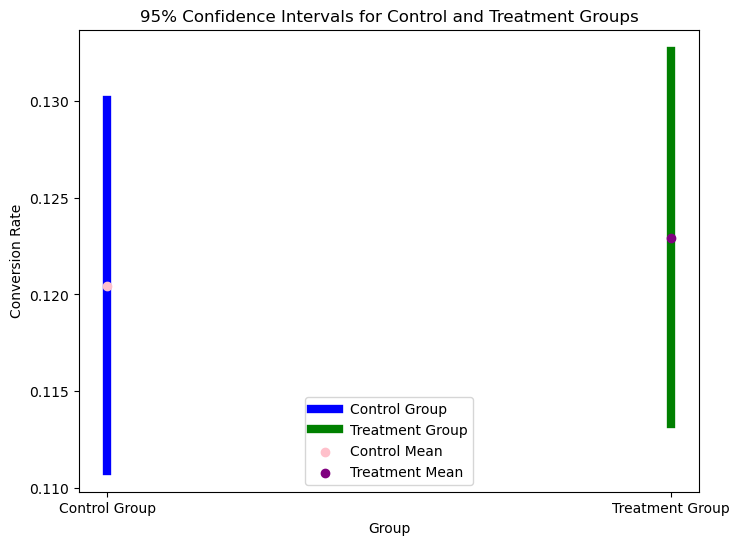

In [135]:
# Создание графика
plt.figure(figsize=(8, 6))

# Построение вертикальных линий для доверительных интервалов
plt.plot([1, 1], [lower_con, upper_con], label='Control Group', color='blue', lw=6)
plt.plot([2, 2], [lower_treat, upper_treat], label='Treatment Group', color='green', lw=6)

# Добавление точек для средней конверсии (среднее значение пропорции)
plt.scatter(1, (lower_con + upper_con) / 2, color='pink', zorder=5, label='Control Mean')
plt.scatter(2, (lower_treat + upper_treat) / 2, color='purple', zorder=5, label='Treatment Mean')

# Настройка графика
plt.xticks([1, 2], ['Control Group', 'Treatment Group'])
plt.title('95% Confidence Intervals for Control and Treatment Groups')
plt.ylabel('Conversion Rate')
plt.xlabel('Group')
plt.legend()

# Показ графика
plt.show()

Выводы

1. **p-value = 0.721** намного больше 0.05, поэтому мы НЕ можем отвергнуть нулевую гипотезу.
2. Новый дизайн не показал статистически значимого улучшения.
3. Доверительный интервал тестовой группы **[11.3%, 13.3%]** включает базовое значение 12%, но не включает целевое 14%.

=> Новый дизайн не привел к значимому улучшению. Нужно вернуться к разработке новых идей